In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.saving import register_keras_serializable
import segyio
import scipy.io as sio
from scipy.signal import butter, filtfilt
import os

2025-01-20 23:04:12.881824: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-20 23:04:12.898243: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737389052.912559  122060 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737389052.916055  122060 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-20 23:04:12.931233: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
def predict_large_image_with_overlap(model, image, patch_size, overlap):
    """
    Predict large image with overlapping patches to reduce artifacts.
    """
    img_height, img_width, img_channels = image.shape
    patch_height, patch_width = patch_size
    step_h = patch_height - overlap
    step_w = patch_width - overlap

    # Padding to make divisible
    pad_h = (patch_height - img_height % step_h) % step_h
    pad_w = (patch_width - img_width % step_w) % step_w
    padded_image = np.pad(image, ((0, pad_h), (0, pad_w), (0, 0)), mode='reflect')

    padded_height, padded_width, _ = padded_image.shape
    prediction = np.zeros_like(padded_image, dtype=np.float32)
    weight_map = np.zeros_like(padded_image, dtype=np.float32)

    for i in range(0, padded_height - patch_height + 1, step_h):
        for j in range(0, padded_width - patch_width + 1, step_w):
            patch = padded_image[i:i+patch_height, j:j+patch_width, :]
            patch = np.expand_dims(patch, axis=0)
            pred_patch = model.predict(patch, verbose=0)[0]
            
            prediction[i:i+patch_height, j:j+patch_width, :] += pred_patch
            weight_map[i:i+patch_height, j:j+patch_width, :] += 1

    # Normalize by weight_map
    prediction /= np.maximum(weight_map, 1)
    return prediction[:img_height, :img_width, :]


def predict_large_image(model, image, patch_size, padding_mode='constant'):
    """
    Predict a large image using a model trained on patch data.
    
    Args:
        model: Trained TensorFlow/Keras model.
        image: Input image (H, W, C).
        patch_size: Tuple (patch_height, patch_width).
        padding_mode: Mode for padding (e.g., 'reflect', 'constant', etc.).
    
    Returns:
        Reconstructed predicted image with the same size as input.
    """
    # Extract image dimensions
    img_height, img_width, img_channels = image.shape
    patch_height, patch_width = patch_size

    # Calculate padding needed
    pad_h = (patch_height - img_height % patch_height) % patch_height
    pad_w = (patch_width - img_width % patch_width) % patch_width
    
    # Add padding to the image
    padded_image = np.pad(
        image,
        ((0, pad_h), (0, pad_w), (0, 0)),
        mode=padding_mode
    )

    # Extract dimensions of padded image
    padded_height, padded_width, _ = padded_image.shape

    # Initialize an empty array for predictions
    predicted_image = np.zeros_like(padded_image, dtype=np.float32)

    # Slide through the padded image and predict on patches
    for i in range(0, padded_height, patch_height):
        for j in range(0, padded_width, patch_width):
            # Extract patch
            patch = padded_image[i:i+patch_height, j:j+patch_width, :]
            patch = np.expand_dims(patch, axis=0)  # Add batch dimension
            
            # Predict patch
            predicted_patch = model.predict(patch, verbose=0)
            
            # Remove batch dimension and place prediction
            predicted_image[i:i+patch_height, j:j+patch_width, :] = predicted_patch[0]

    # Remove padding to restore original size
    return predicted_image[:img_height, :img_width, :]

def normalized_mean_spectrum(data, sampling_rate):
    """
    Plots the normalized mean spectrum of frequency for a 2D seismic shot gather.
    
    Parameters:
    - data: 2D numpy array (time samples x traces), seismic shot gather data.
    - sampling_rate: Sampling rate in Hz (number of samples per second).
    """
    # Number of time samples and traces
    n_samples, n_traces = data.shape
    
    # Fourier transform along the time axis (axis=0)
    fft_data = np.fft.fft(data, axis=0)
    
    # Calculate the frequency axis
    freq = np.fft.fftfreq(n_samples, d=1/sampling_rate)
    
    # Only keep the positive frequencies
    positive_freq = freq[:n_samples // 2]
    positive_fft = fft_data[:n_samples // 2, :]
    
    # Compute the amplitude spectrum
    amplitude_spectrum = np.abs(positive_fft)
    
    # Mean spectrum across all traces
    mean_spectrum = np.mean(amplitude_spectrum, axis=1)
    
    # Normalize the mean spectrum
    normalized_mean_spectrum = mean_spectrum / np.max(mean_spectrum)

    return positive_freq, normalized_mean_spectrum

def mean_spectrum(data, sampling_rate):
    """
    Plots the normalized mean spectrum of frequency for a 2D seismic shot gather.
    
    Parameters:
    - data: 2D numpy array (time samples x traces), seismic shot gather data.
    - sampling_rate: Sampling rate in Hz (number of samples per second).
    """
    # Number of time samples and traces
    n_samples, n_traces = data.shape
    
    # Fourier transform along the time axis (axis=0)
    fft_data = np.fft.fft(data, axis=0)
    
    # Calculate the frequency axis
    freq = np.fft.fftfreq(n_samples, d=1/sampling_rate)
    
    # Only keep the positive frequencies
    positive_freq = freq[:n_samples // 2]
    positive_fft = fft_data[:n_samples // 2, :]
    
    # Compute the amplitude spectrum
    amplitude_spectrum = np.abs(positive_fft)
    
    # Mean spectrum across all traces
    mean_spectrum = np.mean(amplitude_spectrum, axis=1)
    
    return positive_freq, mean_spectrum


def get_shot_data(data, shot_id, num_trace):
    start_id =  shot_id*num_trace
    end_id   = start_id + num_trace
    return data[:, start_id:end_id]
    
def low_pass_filter_2d(data, cutoff, fs, order, axis):
    """
    Apply a low-pass Butterworth filter to 2D data along a specified axis.
    Args:
        data: 2D array (rows, cols).
        cutoff: Cutoff frequency (Hz).
        fs: Sampling frequency (Hz).
        order: Filter order.
        axis: Axis along which to apply the filter (0 for rows, 1 for columns).
    Returns:
        Low-pass filtered 2D array.
    """
    b, a = butter(order, cutoff / (0.5 * fs), btype='lowpass')
    return filtfilt(b, a, data, axis=axis)

def high_pass_filter_2d(data, cutoff, fs, order, axis):
    """
    Apply a high-pass Butterworth filter to 2D data along a specified axis.
    Args:
        data: 2D array (rows, cols).
        cutoff: Cutoff frequency (Hz).
        fs: Sampling frequency (Hz).
        order: Filter order.
        axis: Axis along which to apply the filter (0 for rows, 1 for columns).
    Returns:
        High-pass filtered 2D array.
    """
    b, a = butter(order, cutoff / (0.5 * fs), btype='highpass')
    return filtfilt(b, a, data, axis=axis)

def pad_to_divisible(image, factor=16):
    h, w = tf.shape(image)[0], tf.shape(image)[1]
    pad_h = (factor - h % factor) % factor
    pad_w = (factor - w % factor) % factor
    padded_image = tf.pad(image, [[0, pad_h], [0, pad_w], [0, 0]], mode='SYMMETRIC')
    return padded_image, h, w

def crop_to_original(padded_output, original_height, original_width):
    return padded_output[:original_height, :original_width, :]


In [3]:
# Set up GPU device
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

In [4]:
def load_shot_gather(path_file):
    with segyio.open(path_file, ignore_geometry=True) as f:
        #01 Get Attribute
        f.mmap()
        field_record_attribute = f.attributes(segyio.TraceField.FieldRecord)[:]
    
        #02 Making template
        shot_data = {}
        for idx_fr in np.unique(field_record_attribute):
            shot_data[idx_fr] = []
    
        #03 Assign Data
        for i in range(f.tracecount):
            header_trace = f.header[i][segyio.TraceField.FieldRecord]
            shot_data[header_trace].append(f.trace[i])
            
    return field_record_attribute, shot_data

In [5]:
def scale_to_minus_one_one(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data)) * 2 - 1

In [6]:
# filepath = "../data/sgy/marmousi_2D.segy"
# # filepath = "../data/sgy/marmousi_2D_v0.segy"

# all_shot_data = []
# with segyio.open(filepath, ignore_geometry=True) as f:
#     for i in range(f.tracecount):
#         all_shot_data.append(f.trace[i])

#         # if i == 6000:
#         #     break
    
#     header = dict(f.header[i])
#     fs = 1/((f.header[i][segyio.TraceField.TRACE_SAMPLE_INTERVAL])*1e-6)

# all_shot_data = np.array(all_shot_data).T

path_file = "../data/sgy/viking_grabben.segy"
field_record_attribute, shot_data = load_shot_gather(path_file)

In [7]:
# shot_id, num_trace = 100, 361
# shot_data = get_shot_data(all_shot_data, shot_id, num_trace)

# shot_data = sio.loadmat(os.path.join("../data/datasets/test/shot5.mat"))["shot"]
# fs = 1 / (2e-3)

csg = np.array(shot_data[50]).T
print(csg.shape)
print(np.max(csg))
print(np.min(csg))

(1500, 120)
1286.5566
-1243.3516


I0000 00:00:1737389070.142783  122060 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1292 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


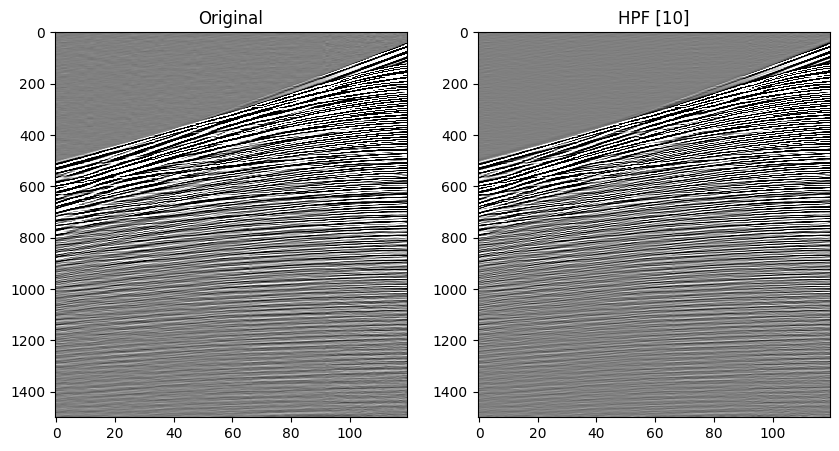

In [8]:
cutoff = 10
order = 3
fs = 1 / (4e-3)
# mean_data = np.mean(shot_data)
# std_data = np.std(shot_data)
# shot_data_norm = (shot_data - mean_data) / std_data
# shot_data_norm = scale_to_minus_one_one(shot_data)
#
shot_data_norm = csg
input_data = high_pass_filter_2d(shot_data_norm, cutoff, fs, order, axis=0)
input_data = tf.expand_dims(input_data, axis=-1)

plt.figure(figsize=(10, 5))
cval = 5
cmap = "gray"
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(shot_data_norm, aspect="auto", cmap=cmap, vmin=-cval, vmax=cval)
plt.subplot(1, 2, 2)
plt.title(f"HPF [{cutoff}]")
plt.imshow(input_data, aspect="auto", cmap=cmap, vmin=-cval, vmax=cval)


## Loading Models

In [20]:
filename = "SSL_100epoch_Real_v1.keras"
# filename = "ssl_v6_model_syn_50_epoch_extent.keras"
model = tf.keras.models.load_model(f"/mnt/d/01_Project/00_LF_Extrapolation_Research/models/{filename}", compile=False)

## Predict Data

In [21]:
# Pad the image
padded_image, orig_h, orig_w = pad_to_divisible(input_data, factor=96)
padded_image = tf.expand_dims(padded_image, axis=0)

print(padded_image.shape)

# Predict
padded_prediction = model.predict(padded_image)

# Crop back to original size
padded_prediction = tf.squeeze(padded_prediction, axis=0)
final_prediction = crop_to_original(padded_prediction, orig_h, orig_w)

# final_prediction = final_prediction * std_data + mean_data

print("Final prediction shape:", final_prediction.shape)

(1, 1536, 192, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
Final prediction shape: (1500, 120, 1)


In [37]:
final_prediction_hpf = high_pass_filter_2d(final_prediction.numpy()[:, :, 0], 3, fs, order, axis=0)

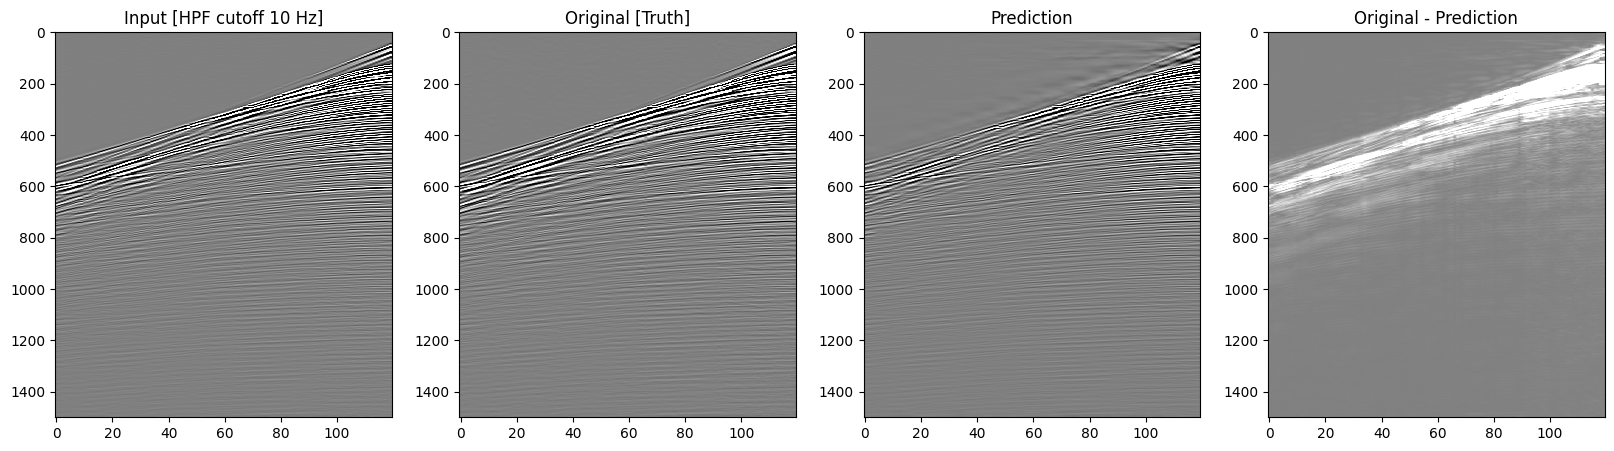

In [38]:
# input_data_denorm = input_data * std_data + mean_data
input_data_denorm = input_data
plt.figure(figsize=(20, 5))
cval = 20
cmap="gray"
plt.subplot(1, 4, 1)
plt.title(f"Input [HPF cutoff {cutoff} Hz]")
plt.imshow(input_data_denorm, aspect="auto", cmap=cmap, vmin=-cval, vmax=cval)
plt.subplot(1, 4, 2)
plt.title("Original [Truth]")
plt.imshow(csg, aspect="auto", cmap=cmap, vmin=-cval, vmax=cval)
plt.subplot(1, 4, 3)
plt.title(f"Prediction")
plt.imshow(final_prediction_hpf, aspect="auto", cmap=cmap, vmin=-cval, vmax=cval)
plt.subplot(1, 4, 4)
plt.title(f"Original - Prediction")
plt.imshow(np.abs(final_prediction_hpf-csg), aspect="auto", cmap=cmap, vmin=-cval, vmax=cval)
# plt.colorbar()

## Single Trace Data and Spectrum

(0.0, 500.0)

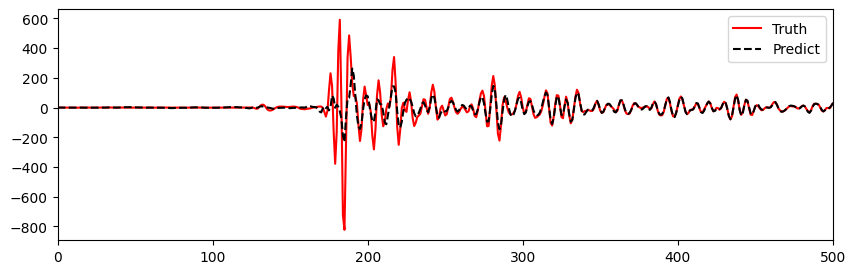

In [46]:
plt.figure(figsize=(10, 3))
idx_trace = 100
plt.plot(csg[:, idx_trace], color="red", label="Truth")
plt.plot(final_prediction_hpf[:, idx_trace], color="black", label="Predict", linestyle="--")
plt.legend()
plt.xlim(0, 500)

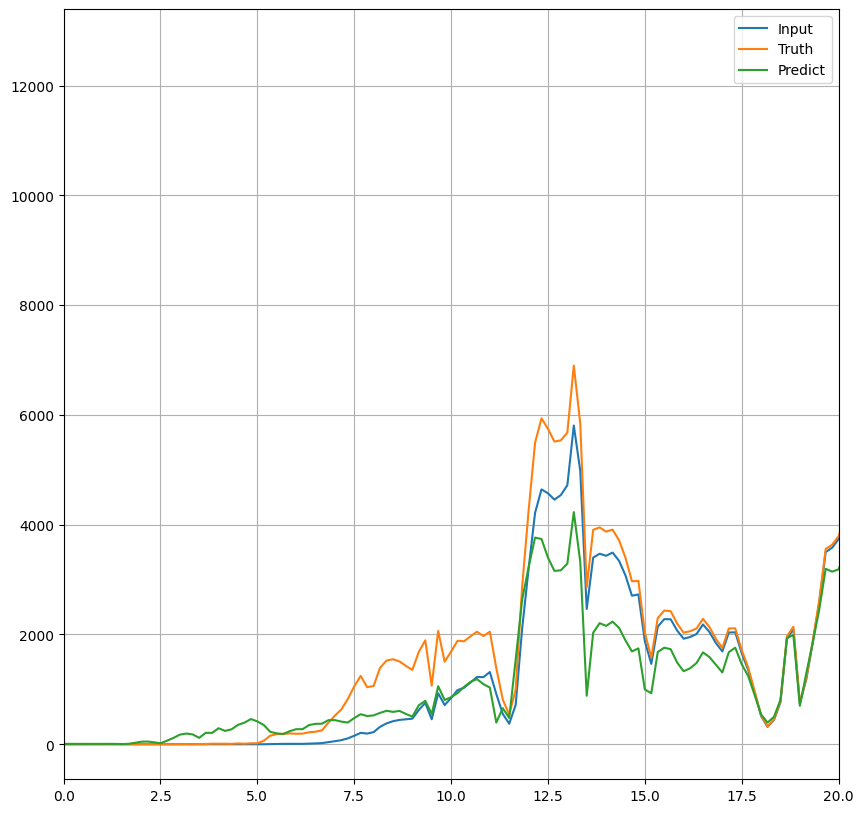

In [41]:
def single_trace_spectrum(trace, sampling_rate):
    """
    Plots the normalized mean spectrum of frequency for a 2D seismic shot gather.
    
    Parameters:
    - data: 2D numpy array (time samples x traces), seismic shot gather data.
    - sampling_rate: Sampling rate in Hz (number of samples per second).
    """
    # Number of time samples and traces
    data = np.expand_dims(trace, axis=1)
    n_samples, n_traces = data.shape
    
    # Fourier transform along the time axis (axis=0)
    fft_data = np.fft.fft(data, axis=0)
    
    # Calculate the frequency axis
    freq = np.fft.fftfreq(n_samples, d=1/sampling_rate)
    
    # Only keep the positive frequencies
    positive_freq = freq[:n_samples // 2]
    positive_fft = fft_data[:n_samples // 2, :]
    
    # Compute the amplitude spectrum
    amplitude_spectrum = np.abs(positive_fft)
    
    return positive_freq, amplitude_spectrum

freq, spectrum_full = single_trace_spectrum(csg[:, idx_trace], fs)
freq, spectrum_input = single_trace_spectrum(input_data_denorm[:, idx_trace, 0], fs)
freq, spectrum_predict = single_trace_spectrum(final_prediction_hpf[:, idx_trace], fs)

plt.figure(figsize=(10, 10))
plt.plot(freq, spectrum_input, label="Input")
plt.plot(freq, spectrum_full, label="Truth")
plt.plot(freq, spectrum_predict, label="Predict")
plt.xlim(0, 20)
plt.grid()
plt.legend()
plt.show()

## Shot Gather Spectrum

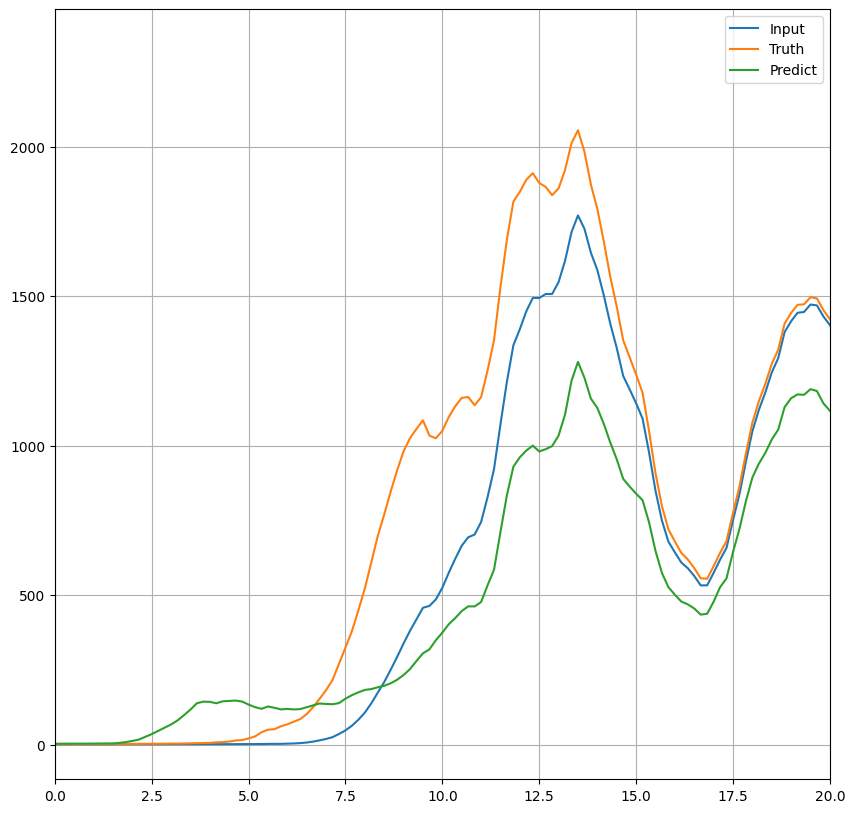

In [42]:
freq, spectrum_full = mean_spectrum(csg, fs)
freq, spectrum_input = mean_spectrum(input_data_denorm[:, :, 0], fs)
freq, spectrum_predict = mean_spectrum(final_prediction_hpf, fs)

plt.figure(figsize=(10, 10))
plt.plot(freq, spectrum_input, label="Input")
plt.plot(freq, spectrum_full, label="Truth")
plt.plot(freq, spectrum_predict, label="Predict")
plt.xlim(0, 20)
plt.grid()
plt.legend()
plt.show()